### XGBoost Recession Predictor


How it works:

1. Start with a base learer: The first model decision tree is trained on the data. In regression tasks this base model simply predicts the average of the target variable
2. Calculate the errors: After training the frist tree, the errors between the predcited and actual values are calculated. 
3. Train the next tree: The next tree is trained on the errors of the previous tree. This step attempts to correct the errors made by the first tree.
4. Repeat the prcoess: This process continues with each new tree trying to correct the errors of the previous trees until a stopping criterion is met.
5. Combine the predictions: The final prediciton is the sum of the predictions from all the trees.


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings

In [ ]:
df = pd.read_csv(r'C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\music_econ_topics_merged.csv')

VISUALS_DIR = r'C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\visuals'

feature_cols = ['danceability', 'energy', 'valence', 'tempo', 
                'acousticness', 'instrumentalness', 'speechiness', 'loudness']
df_clean = df[feature_cols + ['week_date', 'USREC']].dropna()

# Separate features and target
X = df_clean[feature_cols]
y = df_clean['USREC']

print(f" {len(df_clean)} months")
print(f"Normal periods: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"Recession periods: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")



Training set: 455 samples
Test set: 114 samples
 569 months
Normal periods: 496 (87.2%)
Recession periods: 73 (12.8%)


TRAINING XGBOOST MODEL

Scale pos weight: 6.84 (handles class imbalance)
✓ Training complete!
✓ Training complete!

--- Full Dataset Performance ---
              precision    recall  f1-score   support

      Normal      0.918     0.909     0.914        99
   Recession      0.438     0.467     0.452        15

    accuracy                          0.851       114
   macro avg      0.678     0.688     0.683       114
weighted avg      0.855     0.851     0.853       114

ROC-AUC: 0.9037

Confusion Matrix:
                  Predicted
                Normal  Recession
Actual Normal       90         9
       Recession     8         7

✓ Catching 7/15 recessions (46.7% recall)
⚠️  Missing 8 recessions (53.3%)
⚠️  False alarms: 9 (9.1% of normal)


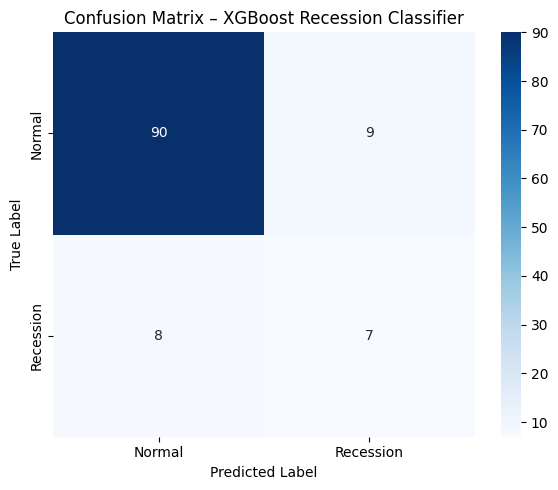

In [ ]:
print("="*70)
print("TRAINING XGBOOST MODEL")
print("="*70)

scale_pos_weight = (y==0).sum() / (y==1).sum()
print(f"\nScale pos weight: {scale_pos_weight:.2f} (handles class imbalance)")

xgb_model = XGBClassifier(
    n_estimators=150, #increased trees to get better results
    max_depth=3,
    learning_rate=0.05,
    min_child_weight=5, #by adding 5 samples per leaf, I'm tying to reduce noise.
    subsample=0.8,  #feature said to improve accuracy
    colsample_bytree=0.8, # by only using 80% of features, I allow the model to get better ideeas of feature importance
    scale_pos_weight=scale_pos_weight, # Cool technique to make recession errors be worse than false alarms
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X, y)

# Predictions
y_pred = xgb_model.predict(X)
y_proba = xgb_model.predict_proba(X)[:, 1]

print("✓ Training complete!")

# Performance
print("\n--- Full Dataset Performance ---")
print(classification_report(y, y_pred, target_names=['Normal', 'Recession'], digits=3))

roc_auc = roc_auc_score(y, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
print(f"\nConfusion Matrix:")
print(f"                  Predicted")
print(f"                Normal  Recession")
print(f"Actual Normal     {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"       Recession  {cm[1,0]:4d}      {cm[1,1]:4d}")

recall = cm[1,1] / (cm[1,0] + cm[1,1])
precision = cm[1,1] / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) > 0 else 0

print(f"\n✓ Catching {cm[1,1]}/{cm[1,0] + cm[1,1]} recessions ({recall*100:.1f}% recall)")
print(f"⚠️  Missing {cm[1,0]} recessions ({(1-recall)*100:.1f}%)")
print(f"⚠️  False alarms: {cm[0,1]} ({cm[0,1]/(cm[0,0]+cm[0,1])*100:.1f}% of normal)")
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'Recession'],
    yticklabels=['Normal', 'Recession']
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – XGBoost Recession Classifier")
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE ANALYSIS


danceability        : 0.2484 ████████████████████████
speechiness         : 0.1364 █████████████
loudness            : 0.1313 █████████████
tempo               : 0.1065 ██████████
acousticness        : 0.1038 ██████████
energy              : 0.0980 █████████
instrumentalness    : 0.0907 █████████
valence             : 0.0849 ████████

🔑 Top 3 Predictors:
  1. danceability         (24.8%)
  7. speechiness          (13.6%)
  8. loudness             (13.1%)


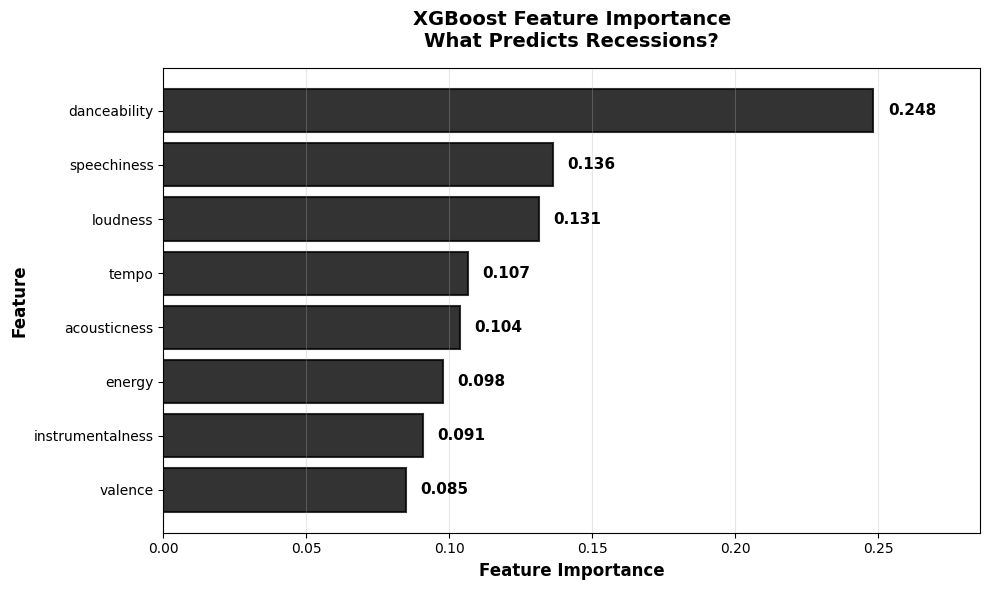


✓ Saved: xgb_feature_importance.png


In [ ]:
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n")
for idx, row in importance_df.iterrows():
    bar = '█' * int(row['Importance'] * 100)
    print(f"{row['Feature']:20s}: {row['Importance']:.4f} {bar}")

print(f"\n🔑 Top 3 Predictors:")
for i, row in importance_df.head(3).iterrows():
    print(f"  {i+1}. {row['Feature']:20s} ({row['Importance']:.1%})")

# ==================== VISUALIZE ====================

fig, ax = plt.subplots(figsize=(10, 6))

# Sort for plotting
features_sorted = importance_df['Feature'].values
importance_sorted = importance_df['Importance'].values

# Color code: top 3 in red, rest in blue
#colors = ['#e74c3c' if i < 3 else '#3498db' for i in range(len(features_sorted))]
colors = ['black']

bars = ax.barh(features_sorted, importance_sorted, color=colors, alpha=0.8, 
               edgecolor='black', linewidth=1.5)

# Add value labels
for i, (feat, imp) in enumerate(zip(features_sorted, importance_sorted)):
    ax.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontweight='bold', fontsize=11)

ax.set_xlabel('Feature Importance', fontweight='bold', fontsize=12)
ax.set_ylabel('Feature', fontweight='bold', fontsize=12)
ax.set_title('XGBoost Feature Importance\nWhat Predicts Recessions?', 
             fontweight='bold', fontsize=14, pad=15)
ax.invert_yaxis()  # Highest importance at top
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim([0, max(importance_sorted) * 1.15])

plt.tight_layout()
plt.savefig(f'{VISUALS_DIR}/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: xgb_feature_importance.png")

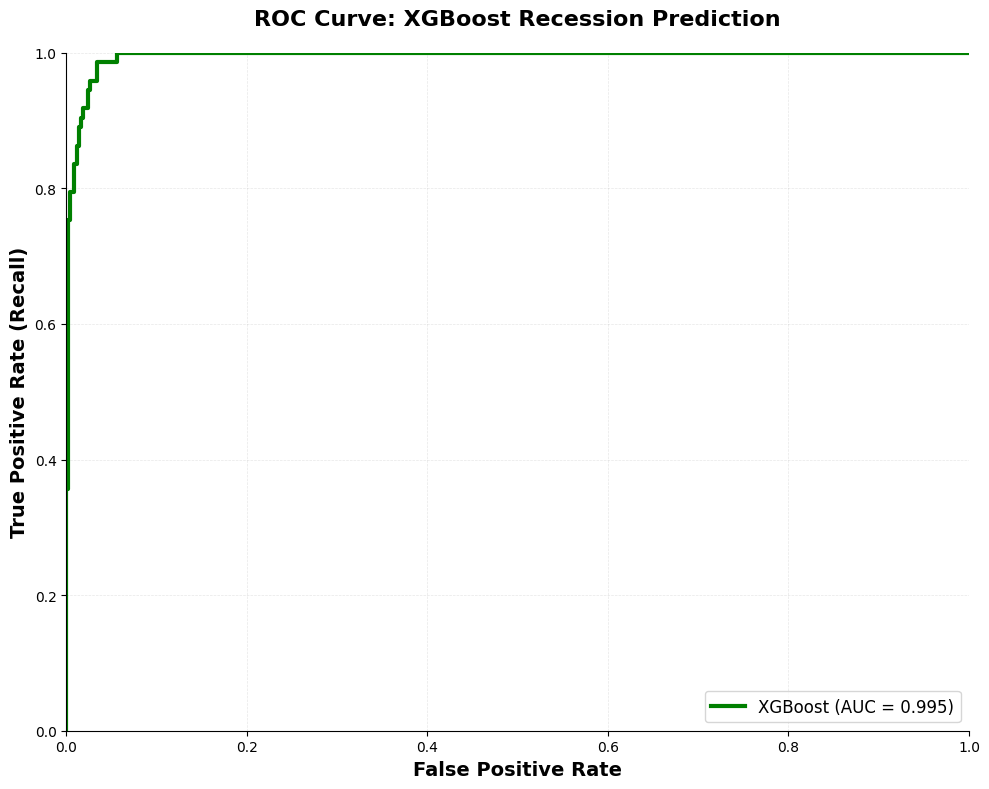

ROC AUC: 0.9948


In [ ]:
# Calculate ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)

# Create clean ROC plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC curve
ax.plot(fpr, tpr, color='green', lw=3, 
        label=f'XGBoost (AUC = {roc_auc:.3f})')

# Plot diagonal reference
#ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
  #      label='Random Classifier (AUC = 0.500)')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate (Recall)', fontsize=14, fontweight='bold')
ax.set_title('ROC Curve: XGBoost Recession Prediction', 
             fontsize=16, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Legend
ax.legend(loc='lower right', fontsize=12)

# Clean spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")

✓ Loaded 569 months of data
✓ Date range: 1974-01-31 00:00:00 to 2021-05-31 00:00:00
✓ Recession months: 73

✓ Time series saved as: danceability_timeseries.png


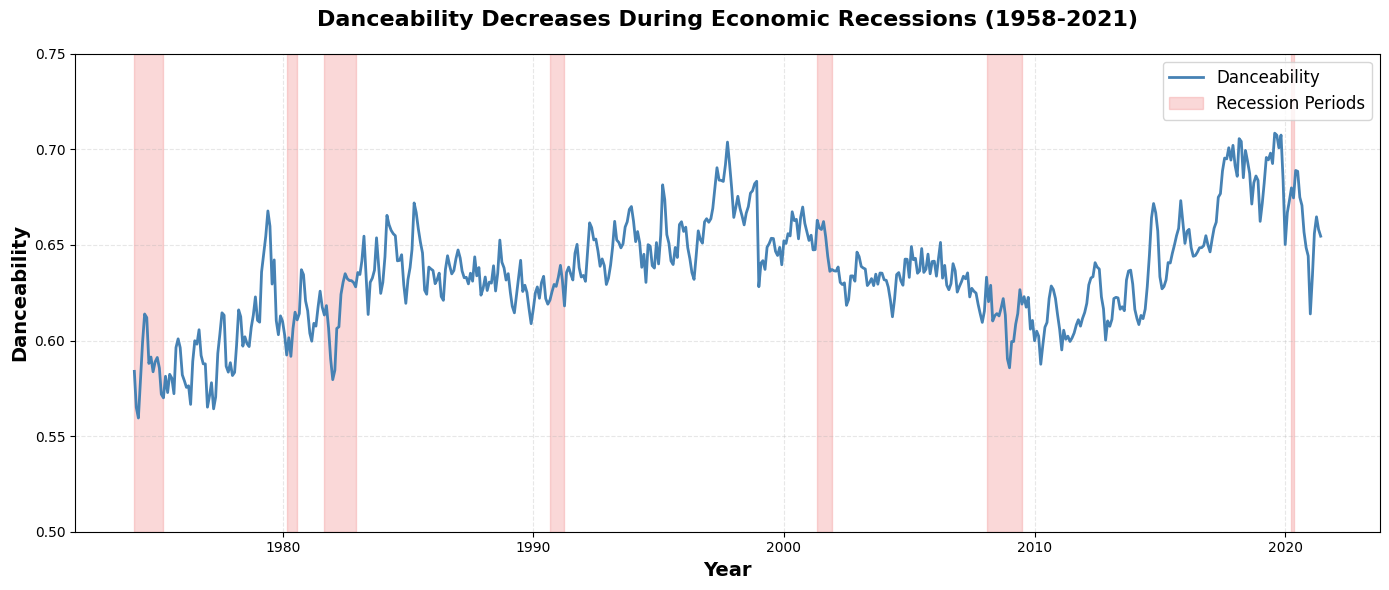

✓ Multi-feature time series saved as: all_features_timeseries.png


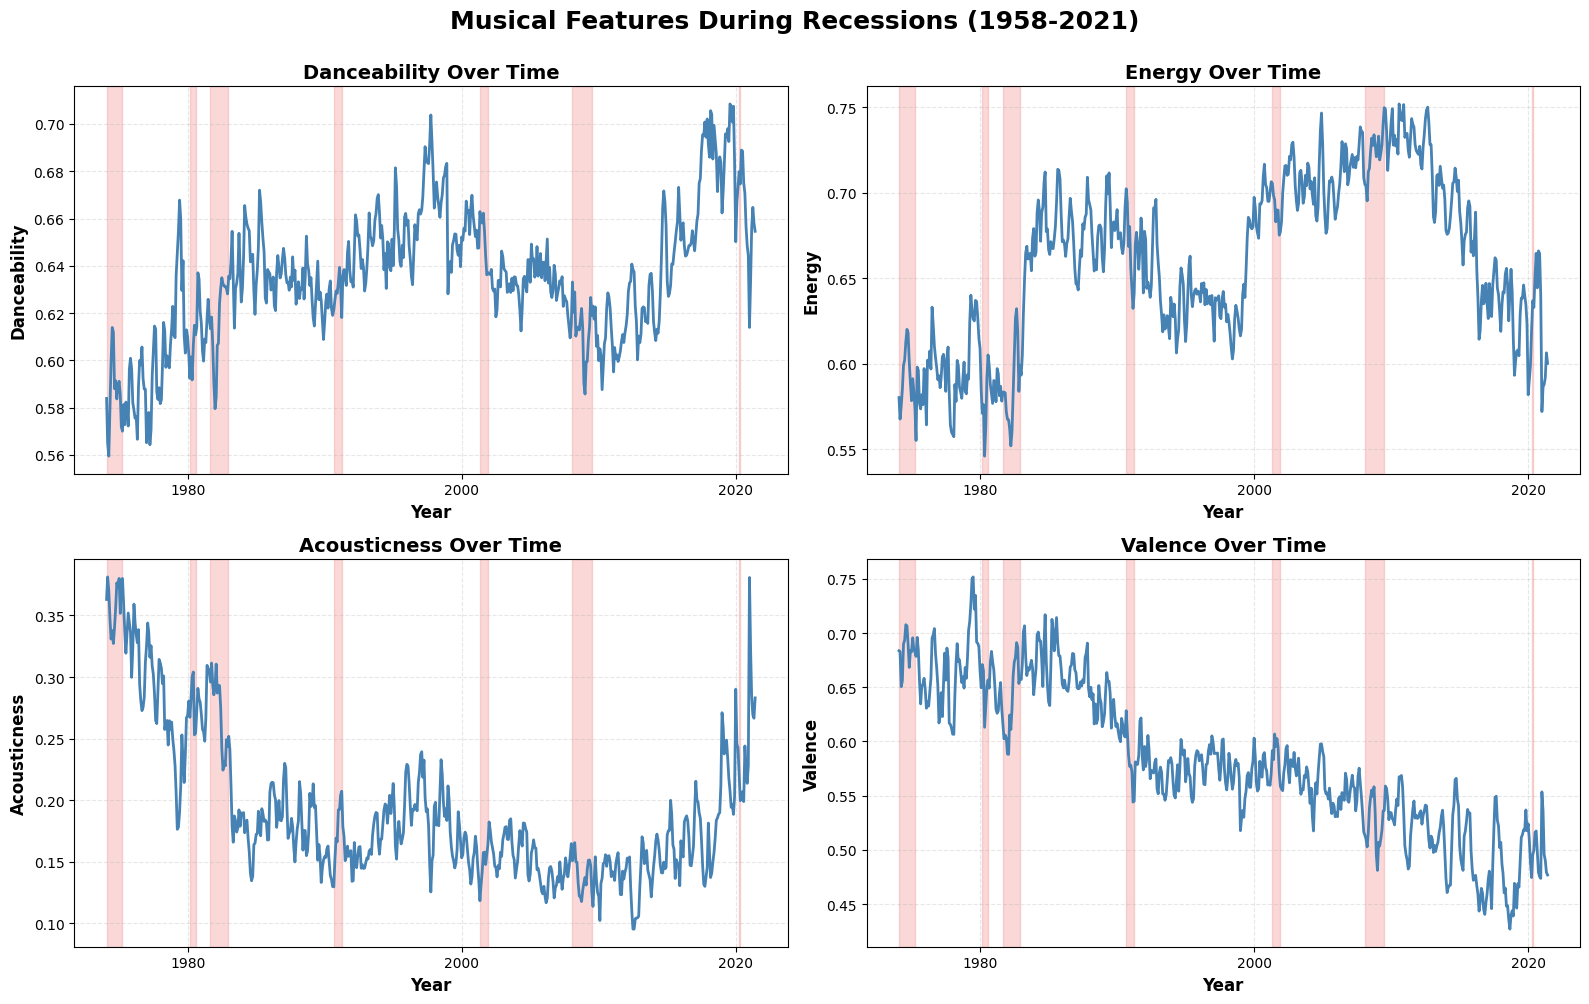

✓ Comparison chart saved as: features_comparison.png


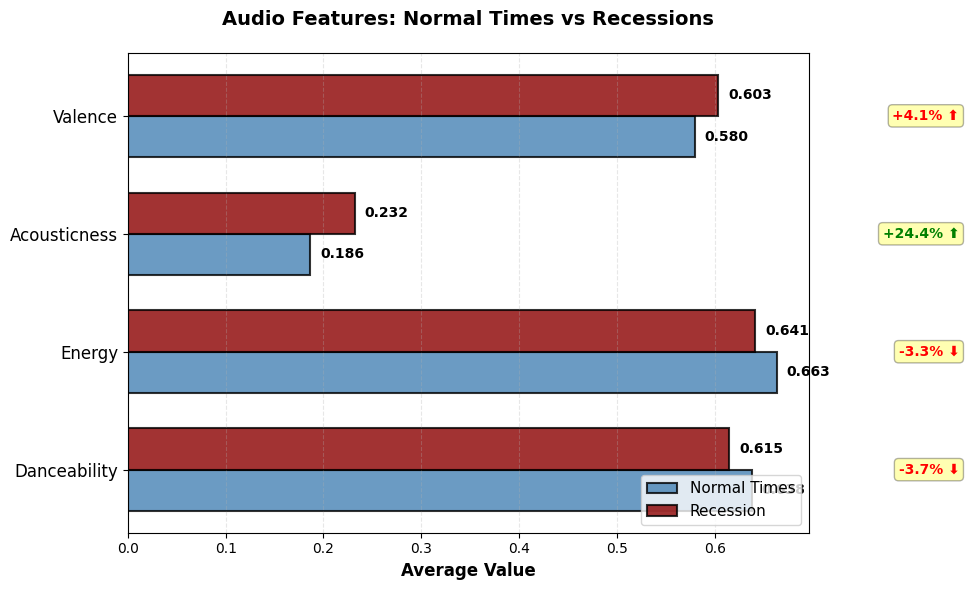


ALL VISUALIZATIONS CREATED SUCCESSFULLY!

Files created:
1. danceability_timeseries.png
2. all_features_timeseries.png
3. features_comparison.png

Ready to add to your poster!


In [ ]:
# ============================================================================
# STEP 1: IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# ============================================================================
# STEP 2: LOAD YOUR DATA
# ============================================================================

# Replace this path with YOUR actual file path
df = pd.read_csv('music_econ_topics_merged.csv')

# ============================================================================
# STEP 3: PREPARE DATA
# ============================================================================

feature_cols = ['danceability', 'energy', 'valence', 'tempo', 
                'acousticness', 'instrumentalness', 'speechiness', 'loudness']

# Clean data - remove any rows with missing values
df_clean = df[feature_cols + ['week_date', 'USREC']].dropna()

# Convert week_date to datetime if it's not already
df_clean['week_date'] = pd.to_datetime(df_clean['week_date'])

# Sort by date (important for time series!)
df_clean = df_clean.sort_values('week_date').reset_index(drop=True)

print(f"✓ Loaded {len(df_clean)} months of data")
print(f"✓ Date range: {df_clean['week_date'].min()} to {df_clean['week_date'].max()}")
print(f"✓ Recession months: {(df_clean['USREC']==1).sum()}")

# ============================================================================
# STEP 4: CREATE TIME SERIES PLOT
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 6))

# Plot danceability over time
ax.plot(df_clean['week_date'], df_clean['danceability'], 
        linewidth=2, color='steelblue', label='Danceability', zorder=3)

# Shade recession periods
# Find contiguous recession periods
df_clean['recession_group'] = (df_clean['USREC'] != df_clean['USREC'].shift()).cumsum()

for group, data in df_clean[df_clean['USREC'] == 1].groupby('recession_group'):
    ax.axvspan(data['week_date'].min(), data['week_date'].max(), 
               alpha=0.3, color='lightcoral', zorder=1)

# Add a recession patch for legend
recession_patch = mpatches.Patch(color='lightcoral', alpha=0.3, label='Recession Periods')

ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Danceability', fontsize=14, fontweight='bold')
ax.set_title('Danceability Decreases During Economic Recessions (1958-2021)', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(handles=[ax.get_lines()[0], recession_patch], fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(0.5, 0.75)

# Format x-axis
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('danceability_timeseries.png', dpi=300, bbox_inches='tight')
print("\n✓ Time series saved as: danceability_timeseries.png")
plt.show()

# ============================================================================
# OPTIONAL: CREATE MULTIPLE FEATURE TIME SERIES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
features_to_plot = ['danceability', 'energy', 'acousticness', 'valence']
titles = ['Danceability', 'Energy', 'Acousticness', 'Valence']

for idx, (feature, title) in enumerate(zip(features_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Plot feature
    ax.plot(df_clean['week_date'], df_clean[feature], 
            linewidth=2, color='steelblue', label=title)
    
    # Shade recessions
    for group, data in df_clean[df_clean['USREC'] == 1].groupby('recession_group'):
        ax.axvspan(data['week_date'].min(), data['week_date'].max(), 
                   alpha=0.3, color='lightcoral', zorder=1)
    
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel(title, fontsize=12, fontweight='bold')
    ax.set_title(f'{title} Over Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.xaxis.set_major_locator(mdates.YearLocator(20))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.suptitle('Musical Features During Recessions (1958-2021)', 
             fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('all_features_timeseries.png', dpi=300, bbox_inches='tight')
print("✓ Multi-feature time series saved as: all_features_timeseries.png")
plt.show()

# ============================================================================
# BONUS: BEFORE/AFTER COMPARISON BAR CHART
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

features = ['danceability', 'energy', 'acousticness', 'valence']
normal_means = df_clean[df_clean['USREC']==0][features].mean()
recession_means = df_clean[df_clean['USREC']==1][features].mean()

y_pos = np.arange(len(features))
width = 0.35

bars1 = ax.barh(y_pos - width/2, normal_means, width, 
                label='Normal Times', color='steelblue', alpha=0.8, 
                edgecolor='black', linewidth=1.5)
bars2 = ax.barh(y_pos + width/2, recession_means, width, 
                label='Recession', color='darkred', alpha=0.8,
                edgecolor='black', linewidth=1.5)

ax.set_yticks(y_pos)
ax.set_yticklabels([f.capitalize() for f in features], fontsize=12)
ax.set_xlabel('Average Value', fontsize=12, fontweight='bold')
ax.set_title('Audio Features: Normal Times vs Recessions', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, axis='x', linestyle='--')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        ax.text(width_val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width_val:.3f}', ha='left', va='center', 
                fontsize=10, fontweight='bold')

# Add difference annotations
for i, feature in enumerate(features):
    diff = recession_means[feature] - normal_means[feature]
    diff_pct = (diff / normal_means[feature]) * 100
    
    if abs(diff_pct) > 2:  # Only show if >2% change
        arrow = '⬆️' if diff > 0 else '⬇️'
        color = 'green' if feature == 'acousticness' and diff > 0 else 'red'
        ax.text(0.85, i, f'{diff_pct:+.1f}% {arrow}', 
                ha='right', va='center', fontsize=10, 
                fontweight='bold', color=color,
                bbox=dict(boxstyle='round,pad=0.3', 
                         facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig('features_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Comparison chart saved as: features_comparison.png")
plt.show()

print("\n" + "="*60)
print("ALL VISUALIZATIONS CREATED SUCCESSFULLY!")
print("="*60)
print("\nFiles created:")
print("1. danceability_timeseries.png")
print("2. all_features_timeseries.png")
print("3. features_comparison.png")
print("\nReady to add to your poster!")

In [ ]:
# Just run this to see what columns you have
import pandas as pd
df = pd.read_csv(r'C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\music_econ_topics_merged.csv')
print(df.columns.tolist())

['week_date', 'danceability', 'energy', 'valence', 'acousticness', 'tempo', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'key', 'mode', 'neg', 'neu', 'pos', 'compound', 'num_songs_on_chart', 'spotify_track_explicit', 'Peak Position', 'Weeks on Chart', 'year', 'month', 'day_of_year', 'week_of_year', 'quarter', 'is_holiday_season', 'DATE', 'USREC', 'UNRATE', 'GDP', 'CPIAUCSL', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', 'dominant_topic', 'dominant_prob', 'second_topic', 'second_prob', 'dominant_topic_label', 'second_topic_label']


In [ ]:
# Add year to your features
df_clean['year'] = pd.to_datetime(df_clean['week_date']).dt.year

# Train model WITH year
feature_cols_with_year = feature_cols + ['year']
X_train_year = df_train[feature_cols_with_year]

# Train XGBoost
model_with_year = XGBoost(...)
model_with_year.fit(X_train_year, y_train)

# Check feature importance
print(model_with_year.feature_importances_)

NameError: name 'df_train' is not defined